# FORTUNE-TELLING WITH PYTHON: AN INTRO TO TIME SERIES MODELING
### Jonathan Balaban
Connect with me on [LinkedIn](https://www.linkedin.com/in/jbalaban) and [Github](https://github.com/ultimatist)

## Introduction
We often refer to our input features in machine learning as "dimensions". On that note, there's a dimension that pervades almost everything we do and observe as humans. It's the fourth dimension we experience every waking moment: time. But time is quite unlike other data we capture, and often requires unique machine learning approaches. These models and approaches are fairly established in the R language, but have more recently immigrated to Python.

In regession and classification, we use features (collected during a cross-sectional study/survey/measurement) to predict an outcome. The model and parameters represent part of the underlying relationship between features and outcome. But what if we run out of funds to cross-section (it's possible), or need to predict future outcomes for which the features aren't measurable or don't yet exist?

### Examples of time series data and modeling (constant time interval):
- Hedge fund prediction of stock and index movements
- Long and short-term weather forecasting
- Business budgeting and trend analysis
- Health vitals monitoring
- Traffic flows and logistic optimization modeling
- Can you think of others?

Time series data usually contains more than meets the eye, and can often be decomposed into trend, seasonal, and random fluctuation components.

![Decomposition](http://rstatistics.net/wp-content/uploads/2014/09/Multiplicative-Decomposition-of-Time-series.png)

- Trends
    - Up
    - Down
    - Flat
    - Larger trends can be made up of smaller trends
    - There is no defined timeframe for what constitutes a trend; it depends on your goals
- Seasonal Effects
    - Weekend retail sales spikes
    - Holiday shopping
    - Energy requirement changes with annual weather patterns
    - Note: twitter spikes when news happens are not seasonal; they aren't regular and predictable
- Random Fluctuations
    - The human element
    - Aggregations of small influencers
    - Observation errors
    - The smaller this is in relation to Trend and Seasonal, the better we can predict the future
    
Time series models fall into [two camps](http://www.abs.gov.au/websitedbs/D3310114.nsf/home/Time+Series+Analysis:+The+Basics#HOW%20DO%20I%20KNOW%20WHICH%20DECOMPOSITION):
- Additive
    - Data = Trend + Seasonal + Random
    - What we will be using for our modeling
- Multiplicative
    - Data = Trend x Seasonal x Random
    - As easy to fit as Additive if we take the log
    - log(Data) = log(Trend x Seasonal x Random)

We should use multiplicative models when the percentage change of our data is more important than the absolute value change (e.g. stocks, commodities); as the trend rises and our values grow, we see amplitude growth in seasonal and random fluctuations. If our seasonality and fluctuations are stable, we likely have an additive model.

## Time Series Modeling Process
Time series model selection is driven by the Trend and Seasonal components of our raw data. The general approach for analysis looks like this:

1. Plot the data and determine Trends and Seasonality
    1. Difference or take the log of the data (multiple times if needed) to remove trends for [certain model applications](https://en.wikipedia.org/wiki/Stationary_process)
    1. Stationairity is needed for ARMA models
1. Determine if we have additive or multiplicative data patterns
1. Select the appropriate algorithm based on the chart below
1. Determine if model selection is correct with these tools
    - Ljung-Box Test
    - Residual Errors (Normal Distribution with zero mean and constant variance-homoskedastic, i.i.d)
    - Autocorrelation Function (ACF)
    - Partial Autocorrelation Function (PACF)

Algorithm | Trend | Seasonal | Correlations
---|---|---|---
ARIMA | X |X|X
SMA Smoothing |X||
Simple Exponential Smoothing |X||
Seasonal Adjustment |X|X|
Holt's Exponential Smoothing |X||
Holt-Winters |X|X|




## How to achieve and test for stationarity:

- The mean of the series is not a function of time:
![](https://www.analyticsvidhya.com/wp-content/uploads/2015/02/Mean_nonstationary.png)

- The variance of the series is not a function of time (homoscedasticity):
![](https://www.analyticsvidhya.com/wp-content/uploads/2015/02/Var_nonstationary.png)

- The covariance at different lags is not a function of time:
![](https://www.analyticsvidhya.com/wp-content/uploads/2015/02/Cov_nonstationary.png)

[From A Complete Tutorial on Time Series Modeling in R](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/)

- [Info on stationarity](http://www.investopedia.com/articles/trading/07/stationary.asp)
- Plotting Rolling Statistics
    - Plot the moving average/variance and see if it changes with time. This visual technique can be done on different windows, but isn't as rigorously defensible as the test below.
- Dickey-Fuller Test
    - Statistical tests for checking stationarity; the null hypothesis is that the TS is non-stationary. If our test statistic is below an `alpha` value, we _can_ reject the null hypothesis and say that the series is stationary.

$$ Y_t = \rho * Y_{t-1} + \epsilon_t \\$$
$$  Y_t - Y_{t-1} = (\rho - 1) Y_{t - 1} + \epsilon_t \\$$

In [1]:
#!pip install pyflux

import numpy as np
import pandas as pd
import pyflux as pf
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# create a play dataframe from 1-10 (linear and squared) to test how differencing works
play = pd.DataFrame([[x for x in range(1,11)], [x**2 for x in range(1,11)]]).T
play.columns = ['original', 'squared']
play

,original,squared
0,1,1
1,2,4
2,3,9
3,4,16
4,5,25
5,6,36
6,7,49
7,8,64
8,9,81
9,10,100


In [3]:
# stationarize linear series (mean and variance doesn't change for sub-windows)
play.original.diff()
# this is similar to taking a first-order derivative

0    NaN
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: original, dtype: float64

In [4]:
# stationarize squared series
play.squared.diff().diff()
# notice we need to difference twice on an exponential trend, and every time we do, we lose a bit of data

0    NaN
1    NaN
2    2.0
3    2.0
4    2.0
5    2.0
6    2.0
7    2.0
8    2.0
9    2.0
Name: squared, dtype: float64

In [5]:
# stationarize squared with log
np.log(play.squared)
# somewhat works, not as dramatically

0    0.000000
1    1.386294
2    2.197225
3    2.772589
4    3.218876
5    3.583519
6    3.891820
7    4.158883
8    4.394449
9    4.605170
Name: squared, dtype: float64

## Data Prep and EDA

We'll be looking at [monthly average temperatures between 1907-1972](https://datamarket.com/data/set/22o4/mean-monthly-temperature-1907-1972#!ds=22o4&display=line)

In [6]:
# load data, recast columns if needed, convert to datetime
monthly_temp = pd.read_csv('./mean-monthly-temperature-1907-19.csv', skipfooter=2, 
                           infer_datetime_format=True, header=1, index_col=0, names=['month', 'temp'])
#monthly_temp.temp = monthly_temp.temp.astype(float)
monthly_temp.index = monthly_temp.index.to_datetime()

In [7]:
# describe
monthly_temp.describe()

,temp
count,791.000000
mean,53.579267
std,15.809023
min,11.200000
25%,39.700000
50%,52.200000
75%,67.200000
max,82.400000


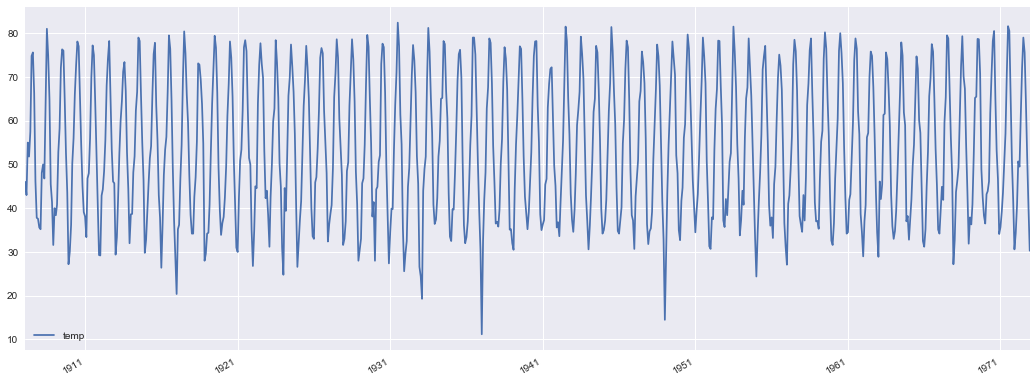

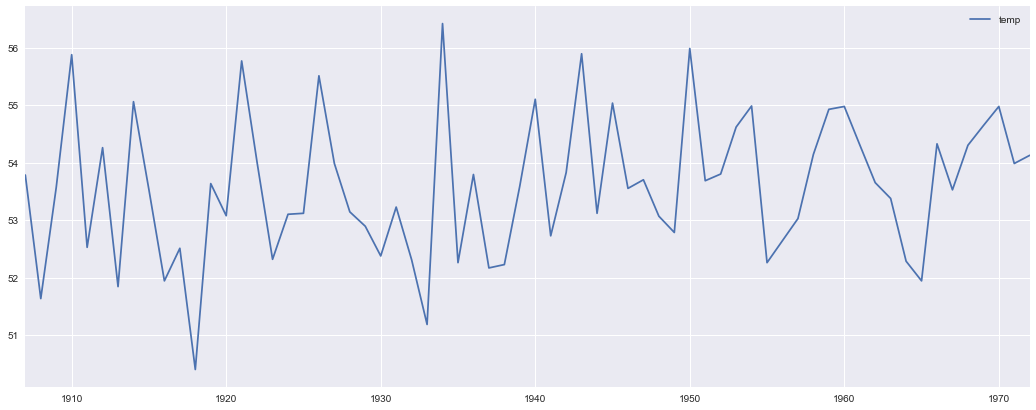

In [8]:
# resample to annual and plot each
annual_temp = monthly_temp.resample('A').mean()
monthly_temp.plot();
annual_temp.plot();

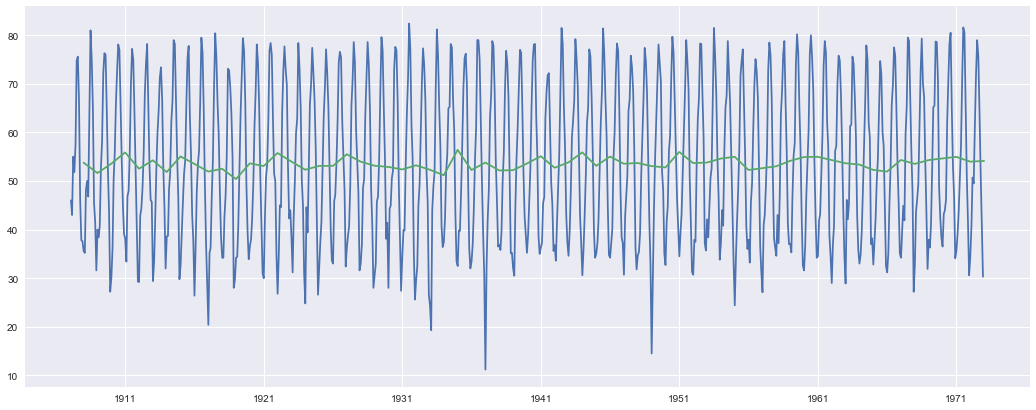

In [9]:
# plot both on same figure
plt.plot(monthly_temp)
plt.plot(annual_temp);

# note, easier to see trends on resampled or moving average charts

In [10]:
# plot with plotly
import plotly.plotly as py
import plotly.graph_objs as go

data = [go.Scatter(x=annual_temp.index, y=annual_temp.temp)]
py.iplot(data)

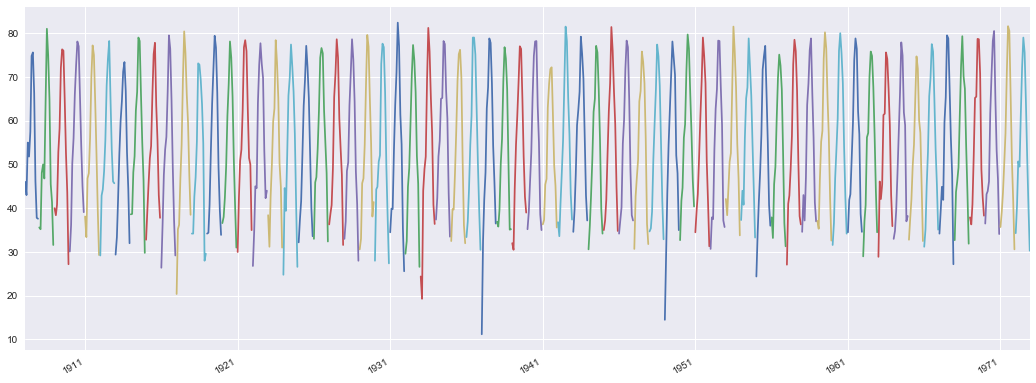

In [11]:
# plot binned yearly segments using resample method
monthly_temp.resample('A').temp.plot();

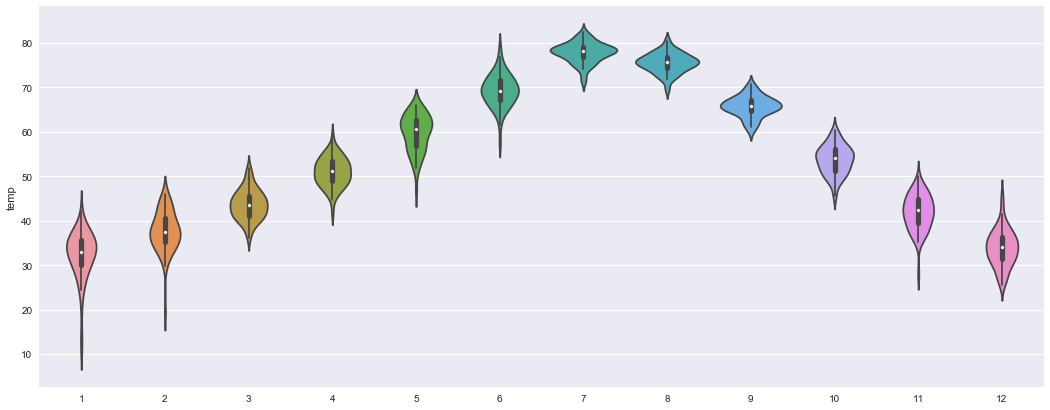

In [12]:
# violinplot months to determine variance and range
sns.violinplot(x=monthly_temp.index.month, y=monthly_temp.temp);

Are these datasets stationary? We can look at a few things per the list above, including a visual check (there seems to be a small upward trend in the annual, too hard to tell for monthly), a standard deviation check on various differences (smallest one is usually most stationary), and the formal Dickey-Fuller test.

In [13]:
# check montly deviations for various diffs
print(monthly_temp.temp.std())
print(monthly_temp.temp.diff().std())
print(monthly_temp.temp.diff().diff().std()) # theoretically lowest, but one above is close enough
print(monthly_temp.temp.diff().diff().diff().std())

15.8090232196005
9.450587792111287
9.241200911372609
14.694817750336801


In [14]:
# check annual deviations for various diffs
print(annual_temp.temp.std()) # looks stationary as is
print(annual_temp.temp.diff().std())
print(annual_temp.temp.diff().diff().std())
print(annual_temp.temp.diff().diff().diff().std())

1.248776111792632
1.7922137983207937
3.1455763100787753
5.816594947757029


In [15]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

Test Statistic                -6.439509e+00
p-value                        1.621275e-08
#Lags Used                     2.100000e+01
Number of Observations Used    7.690000e+02
Critical Value (5%)           -2.865306e+00
Critical Value (1%)           -3.438882e+00
Critical Value (10%)          -2.568775e+00
dtype: float64


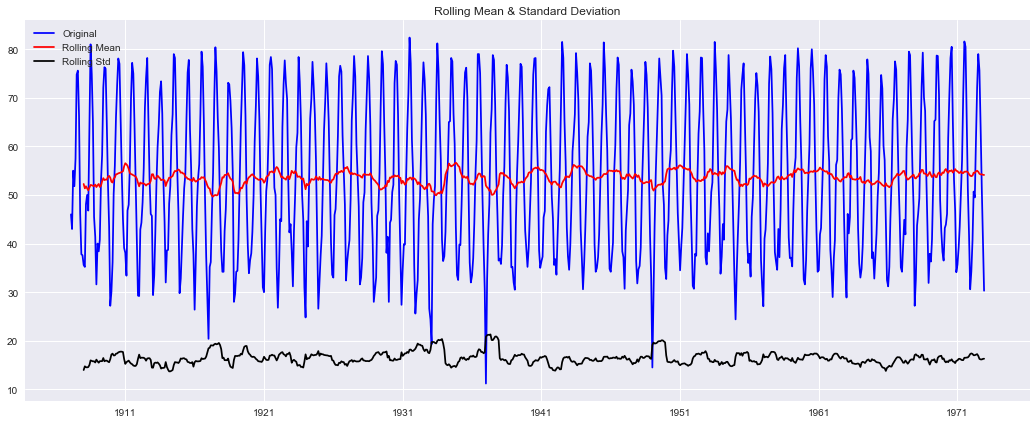

In [16]:
# run DFT on monthly
dftest(monthly_temp.temp)
# p-value allows us to reject a unit root: data is stationary

# this test is ALL ABOUT mean reversion: This process refers to a time series that displays a tendency to
# revert to its historical mean value. Mathematically, such a (continuous) time series is referred to as an Ornstein-Uhlenbeck
# process. This is in contrast to a random walk (Brownian motion), which has no "memory" of where it has been at each particular 
# instance of time. The mean-reverting property of a time series can be exploited for better prediction.

# discuss brownian motion on a chess board

#### SOL

One of the key trading concepts in the quantitative toolbox is that of mean reversion. This process refers to a time series that displays a tendency to revert to its historical mean value. Mathematically, such a (continuous) time series is referred to as an Ornstein-Uhlenbeck process. This is in contrast to a random walk (Brownian motion), which has no "memory" of where it has been at each particular instance of time. The mean-reverting property of a time series can be exploited in order to produce profitable trading strategies.

A continuous mean-reverting time series can be represented by an Ornstein-Uhlenbeck stochastic differential equation:

dxt=θ(μ−xt)dt+σdWt
 
Where θ
 is the rate of reversion to the mean, μ
 is the mean value of the process, σ
 is the variance of the process and Wt
 is a Wiener Process or Brownian Motion.

In a discrete setting the equation states that the change of the price series in the next time period is proportional to the difference between the mean price and the current price, with the addition of Gaussian noise.

This property motivates the Augmented Dickey-Fuller Test, which we will describe below.

https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing

Test Statistic                -8.052998e+00
p-value                        1.721941e-12
#Lags Used                     0.000000e+00
Number of Observations Used    6.500000e+01
Critical Value (5%)           -2.907154e+00
Critical Value (1%)           -3.535217e+00
Critical Value (10%)          -2.591103e+00
dtype: float64


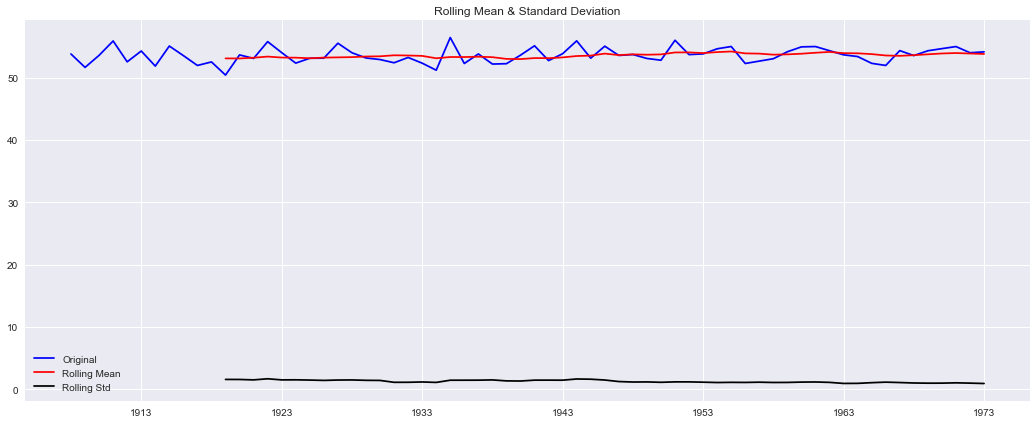

In [17]:
# run DFT on annual
dftest(annual_temp.temp)
# p-value allows us to reject a unit root: data is stationary

# here's an example of non-stationary with DFT results
# dftest(np.exp(annual_temp.temp))

## ARIMA with Statsmodels
Enter [Autoregressive Integrated Moving Average (ARIMA)](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) modeling. When we have autocorrelation between outcomes and their ancestors, we will see a theme, or relationship in the outcome plot. This relationship can be modeled in its own way, allowing us to predict the future with a confidence level commensurate to the strength of the relationship and the proximity to known values (prediction weakens the further out we go).

- [ARIMA in R](https://www.otexts.org/fpp/8/5)
- [Duke ARIMA Guide](https://people.duke.edu/~rnau/411arim2.htm)
- [Great explanation on MA in practice](http://stats.stackexchange.com/questions/164824/moving-average-ma-process-numerical-intuition)

![SARIMA Form](https://www.otexts.org/sites/default/files/fpp/images/sarima1.png)

#### SOL

Other methods that we won't go into:
- Vector autoregressions (VARs)
- Gaussian state space models – often called structural time series or unobserved component models
- GARCH
- Generalized Autoregressive Score (GAS)

In [18]:
# define helper function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

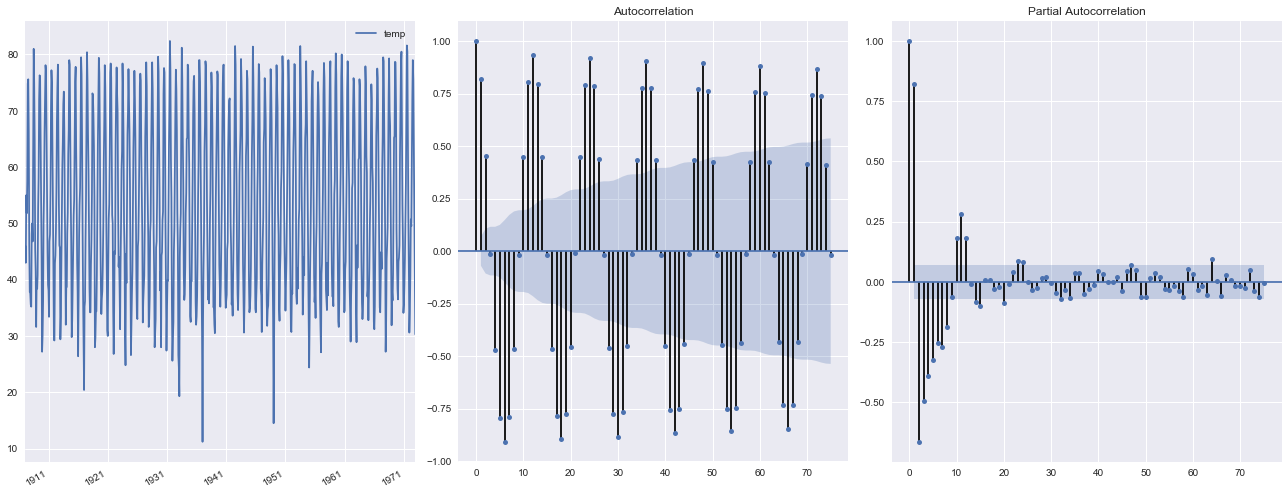

In [19]:
plots(monthly_temp, lags=75);
# open Duke guide for visual
# we note a 12-period cycle (yearly) with suspension bridge design, so must use SARIMA

### [Box-Jenkins Method](https://en.wikipedia.org/wiki/Box–Jenkins_method)

ACF Shape|Indicated Model
---|---
Exponential, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model.
Alternating positive and negative, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to help identify the order.
One or more spikes, rest are essentially zero|Moving average model, order identified by where plot becomes zero.
Decay, starting after a few lags|Mixed autoregressive and moving average (ARMA) model.
All zero or close to zero|Data are essentially random.
High values at fixed intervals|Include seasonal autoregressive term.
No decay to zero|Series is not stationary.

In [20]:
# we might need to install dev version for statespace functionality
#!pip install git+https://github.com/statsmodels/statsmodels.git
import statsmodels.api as sm

# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(monthly_temp.temp, order=(3,0,0), seasonal_order=(0,1,1,12), trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               temp   No. Observations:                  791
Model:             SARIMAX(3, 0, 0)x(0, 1, 1, 12)   Log Likelihood               -2124.762
Date:                            Tue, 02 May 2017   AIC                           4261.525
Time:                                    21:26:52   BIC                           4289.473
Sample:                                         0   HQIC                          4272.275
                                            - 791                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0113      0.008      1.499      0.134      -0.003       0.026
ar.L1          0.1716      0.036      4.793      0.000       0.101       0.242
ar.L2          0.0228      0.036      0.632      0.528      -0.048       0.094
ar.L3          0.0616      0.037      1.672      0.094      -0.011       0.134
ma.S.L12      -0.9997      2.003     -0.499      0.618      -4.926       2.926
sigma2        12.8476     25.614      0.502      0.616     -37.355      63.050
===================================================================================
Ljung-Box (Q):                       21.86   Jarque-Bera (JB):               242.49
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

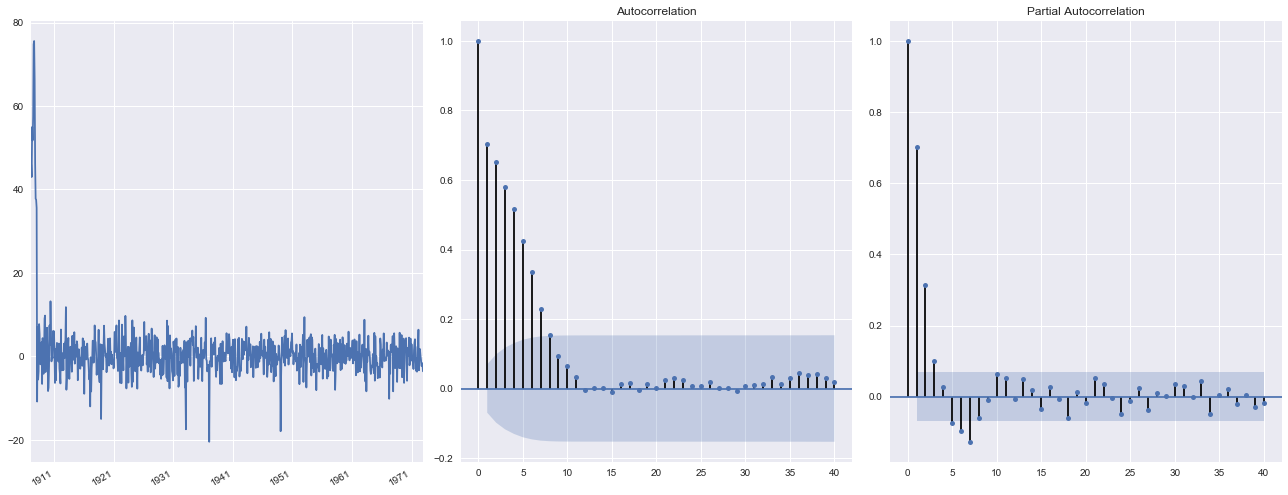

In [21]:
# plot resids
plots(sar.resid, lags=40);

# Thought process:
# 010010 is overdiff by AIC and negative ACR, but 000010 is a big underdiff with better AIC
# we pick 000010,12 and Trend='c' per rule4/5

# now look at seasonal, notice negative ACR spike at 12: per rule 13, we add a SMA term
# big drop to 4284 AIC
# looks like ACR looks good at seasonal lags, so we move back to ARIMA portion

# rule6 says we're a bit underdiff, so we add AR=3 based on PACF: 4261 AIC

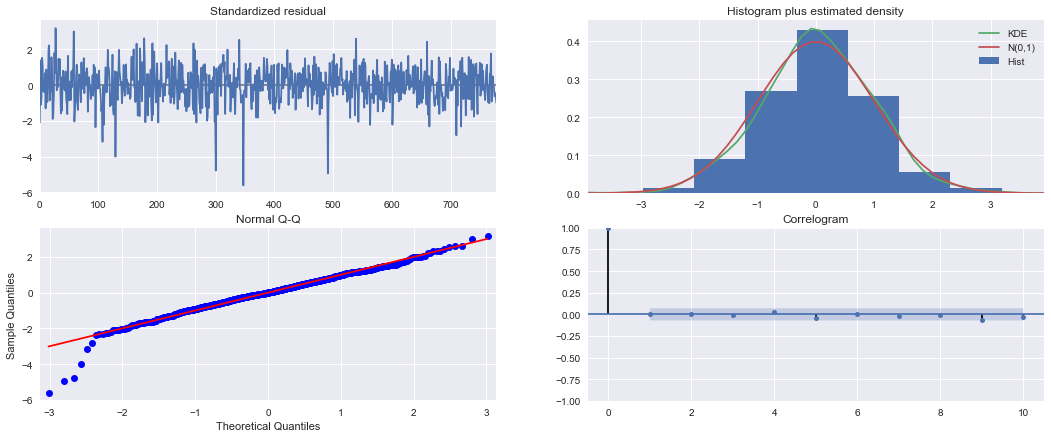

In [22]:
# plot residual diagnostics
sar.plot_diagnostics();

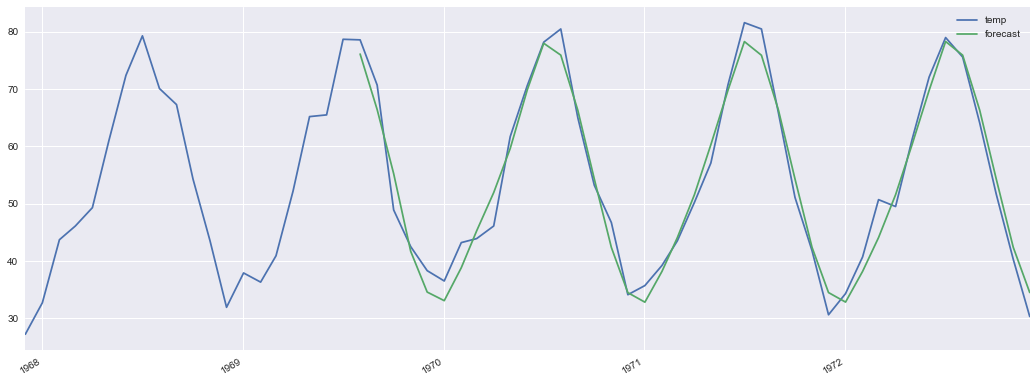

In [23]:
# plot predictions
monthly_temp['forecast'] = sar.predict(start = 750, end= 790, dynamic=10)  
monthly_temp[730:][['temp', 'forecast']].plot();

### Statistical Tests


- [Normality (Jarque-Bera)](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality)
    - Null hypothesis is normally distributed residuals (good, plays well with RMSE and similar error metrics)

- [Serial correlation (Ljung-Box)](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation)
    - Null hypothesis is no serial correlation in residuals (independent of each other)

- [Heteroskedasticity](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity)
    - Tests for change in variance between residuals.
    - The null hypothesis is of no heteroskedasticity. That means different things depending on which alternative is selected:
        - Increasing: Null hypothesis is that the variance is not increasing throughout the sample; that the sum-of-squares in the later subsample is not greater than the sum-of-squares in the earlier subsample.
        - Decreasing: Null hypothesis is that the variance is not decreasing throughout the sample; that the sum-of-squares in the earlier subsample is not greater than the sum-of-squares in the later subsample.
        - Two-sided (default): Null hypothesis is that the variance is not changing throughout the sample. Both that the sum-of-squares in the earlier subsample is not greater than the sum-of-squares in the later subsample and that the sum-of-squares in the later subsample is not greater than the sum-of-squares in the earlier subsample.

- [Durbin Watson](https://en.wikipedia.org/wiki/Durbin–Watson_statistic)
    - Tests autocorrelation of residuals: we want between 1-3, 2 is ideal (no serial correlation)

In [24]:
norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]
lb_val, lb_p = sar.test_serial_correlation(method='ljungbox')[0]
het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]
# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=242.488, p=0.000
Ljung-Box: val=21.860, p=0.991
Heteroskedasticity: val=0.702, p=0.004
Durbin-Watson: d=1.99


### Note on autofit methods
R has an autoARIMA function (and other automagic methods) that gridsearches/optimizes our model parameters for us. Over time, more of these goodies are porting to Python (e.g. statsmodels.tsa.x13 import x13_arima_select_order). While there's nothing wrong with utilizing these resources, the _human makes the final determination!_ Don't become over-reliant on these methods, especially early on when you are grasping the underlying mechanics and theory!

In [25]:
# autoselect for annual, limited to only searching AR and MA parameters

autores = sm.tsa.arma_order_select_ic(annual_temp, ic=['aic', 'bic'], trend='c', max_ar=3, max_ma=3, fit_kw=dict(method='css-mle'))

print('AIC', autores.aic_min_order) # will use this as inputs for annual
print('BIC', autores.bic_min_order)

/Users/jb/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:504: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/jb/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:504: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AIC (0, 0)
BIC (0, 0)


In [26]:
# using itertools to gridsearch solutions
import itertools

#set parameter range; UPDATE THESE!
p = q = range(0, 3)
d = range(0, 2)
season = 12

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
# same for seasonal variant
seasonal_pdq = [(x[0], x[1], x[2], season) for x in list(itertools.product(p, d, q))]

print('SARIMAX: {} , {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} , {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} , {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} , {}'.format(pdq[2], seasonal_pdq[4]))

# https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

SARIMAX: (0, 0, 1) , (0, 0, 1, 12)
SARIMAX: (0, 0, 1) , (0, 0, 2, 12)
SARIMAX: (0, 0, 2) , (0, 1, 0, 12)
SARIMAX: (0, 0, 2) , (0, 1, 1, 12)


## ARIMA with Pyflux

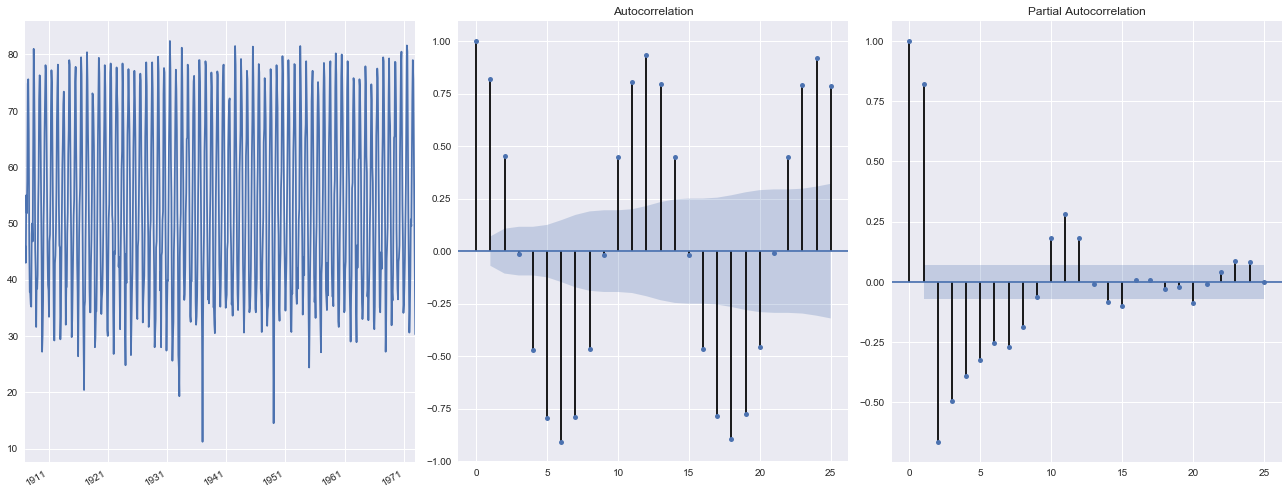

In [27]:
# helper plot
plots(monthly_temp.temp, lags=25)

In [28]:
# build and summarize model
model = pf.ARIMA(data=annual_temp, ar=1, ma=1, integ=0, target='temp')
x = model.fit("MLE")
x.summary()

Normal ARIMA(1,0,1)                                                                                       
======================================================= ==================================================
Dependent Variable: temp                                Method: MLE                                       
Start Date: 1908-12-31 00:00:00                         Log Likelihood: -106.6541                         
End Date: 1972-12-31 00:00:00                           AIC: 221.3083                                     
Number of observations: 65                              BIC: 230.0058                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 53.5799    104.5319   0.5126   0.6083   (-151.3027 | 258.4624)   
AR(1)                                

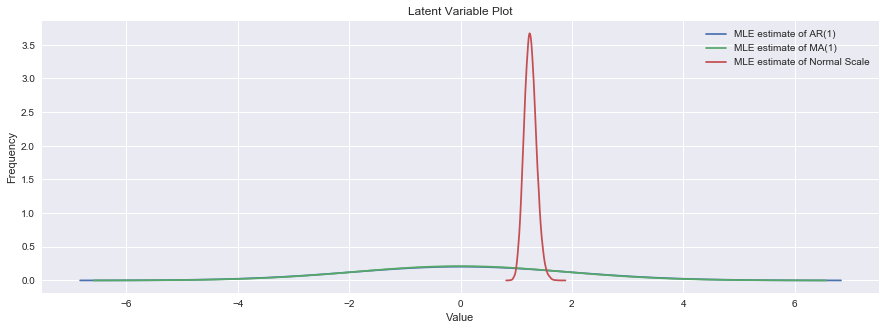

In [29]:
# plot z-scores of feature coefficients
model.plot_z(indices=range(1,9))

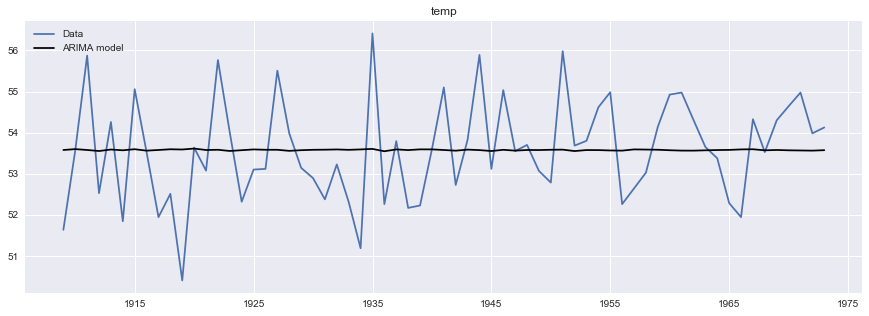

In [30]:
# plot model against raw data
model.plot_fit(figsize=(15,5))

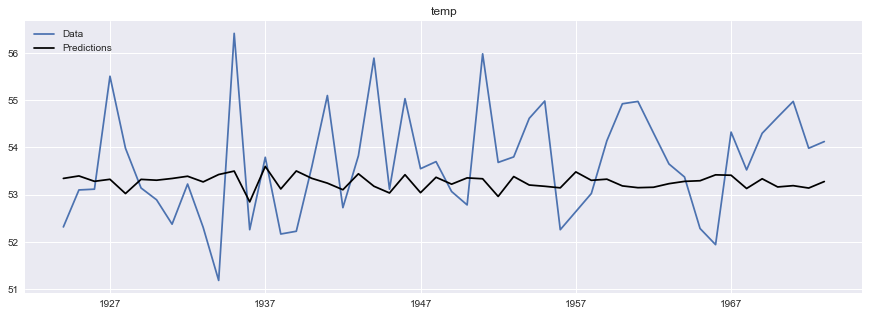

In [31]:
model.plot_predict_is(50,figsize=(15,5))

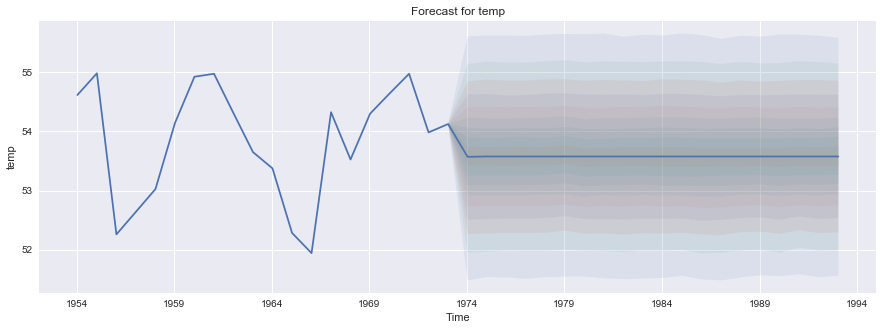

In [32]:
# plot prediction
model.plot_predict(h=20,past_values=20,figsize=(15,5))

In [33]:
# predict future values
model.predict(h=3);

## Predicting Sunspots with Pyflux and ARIMA

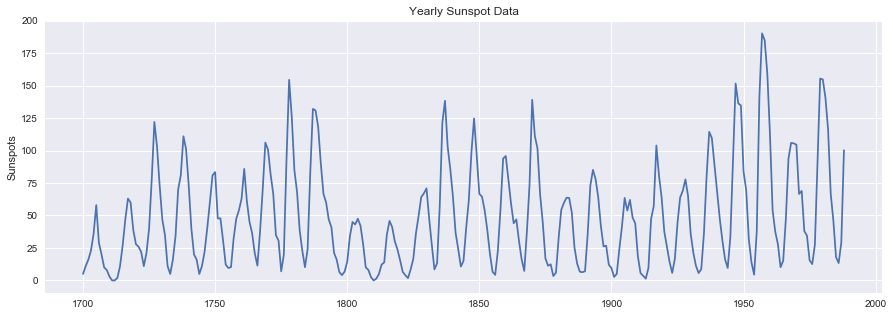

In [34]:
# read and plot data
data = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/datasets/sunspot.year.csv') #
data.index = data['time'].values

plt.figure(figsize=(15,5))
plt.plot(data.index,data['sunspot.year'])
plt.ylabel('Sunspots')
plt.title('Yearly Sunspot Data');

In [35]:
# fit and summarize model
model = pf.ARIMA(data=data,ar=4,ma=4,integ=0,target='sunspot.year')
x = model.fit("MLE")
x.summary()

Normal ARIMA(4,0,4)                                                                                       
======================================================= ==================================================
Dependent Variable: sunspot.year                        Method: MLE                                       
Start Date: 1704                                        Log Likelihood: -1180.5324                        
End Date: 1988                                          AIC: 2381.0648                                    
Number of observations: 285                             BIC: 2417.5897                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 2.6356     1.0926     2.4122   0.0159   (0.494 | 4.7772)         
AR(1)                                

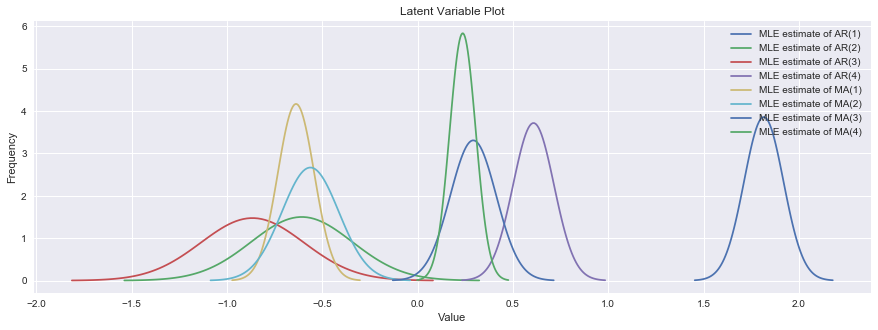

In [36]:
# plot z-scores of feature coefficients
model.plot_z(indices=range(1,9))

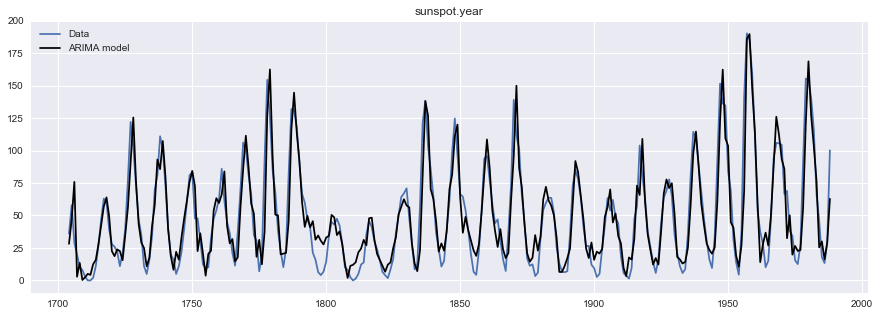

In [37]:
model.plot_fit(figsize=(15,5))

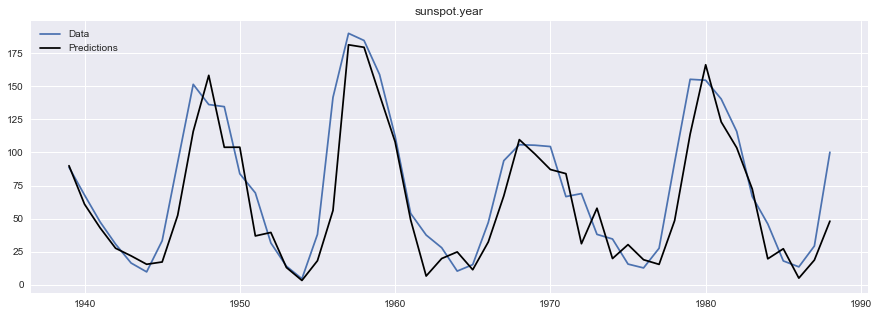

In [38]:
model.plot_predict_is(50,figsize=(15,5))

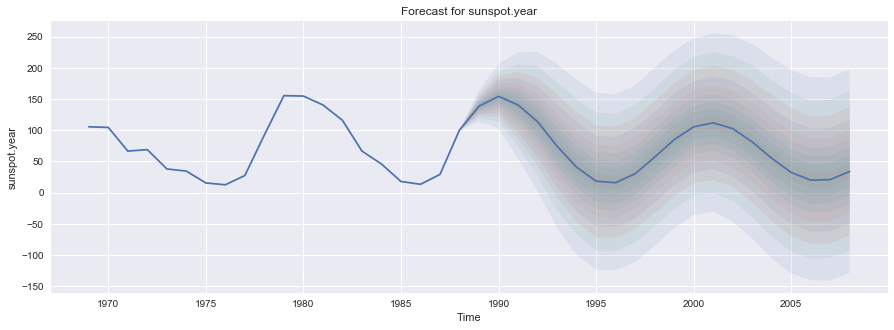

In [39]:
model.plot_predict(h=20,past_values=20,figsize=(15,5))

In [40]:
data.tail()

,Unnamed: 0,time,sunspot.year
1984,285,1984,45.9
1985,286,1985,17.9
1986,287,1986,13.4
1987,288,1987,29.2
1988,289,1988,100.2


In [41]:
model.predict(h=5)

,sunspot.year
1989,138.464513
1990,154.282602
1991,140.500016
1992,113.826086
1993,74.497439


Notes:

be careful about autoarima models in R, consider your metric/criteria.
grab gridsearch method and tweak
BIC vs AIC?

Visual vs formal testing
Logging and differencing for var and trend

## CO2 Levels
Statsmodels has some 'built-in' time series datasets to play with, including one that tracks atmospheric CO2 from continuous air samples at Mauna Loa Observatory in Hawaii. This data includes CO2 samples from MAR 1958 to DEC 2001.

[Credits](https://www.digitalocean.com/community/users/tvincent) 

In [ ]:
# load data
data = sm.datasets.co2.load_pandas()
co2 = data.data

In [43]:
# resample to monthly and check missing values
co2 = co2['co2'].resample('MS').mean()

co2 = co2.fillna(co2.bfill())
co2.isnull().sum()

0

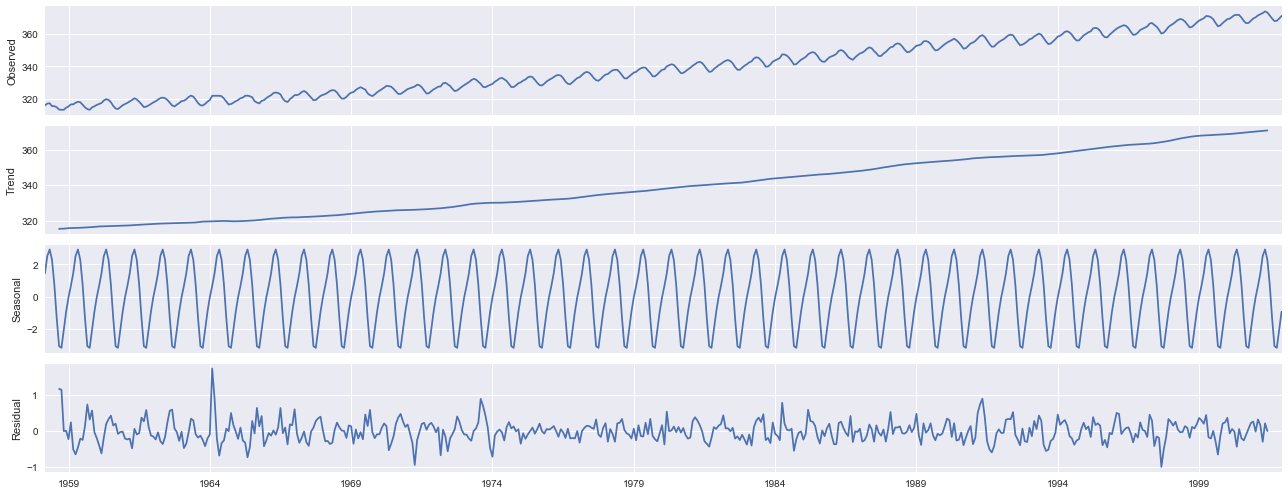

In [ ]:
decomposition = sm.tsa.seasonal_decompose(co2, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
# optimize our SARIMAX model using itertools
#
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(co2,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0),(0, 0, 0, 12)12 - AIC:7612.583429881011
ARIMA(0, 0, 0),(0, 0, 1, 12)12 - AIC:6787.34362404562
ARIMA(0, 0, 0),(0, 0, 2, 12)12 - AIC:6027.256393073634
ARIMA(0, 0, 0),(0, 1, 0, 12)12 - AIC:1854.828234141261
ARIMA(0, 0, 0),(0, 1, 1, 12)12 - AIC:1596.711172763937
ARIMA(0, 0, 0),(0, 1, 2, 12)12 - AIC:1480.7910932052814
ARIMA(0, 0, 0),(1, 0, 0, 12)12 - AIC:1058.9388921320026
ARIMA(0, 0, 0),(1, 0, 1, 12)12 - AIC:1056.2878485978915
ARIMA(0, 0, 0),(1, 0, 2, 12)12 - AIC:1027.9916281266005
ARIMA(0, 0, 0),(1, 1, 0, 12)12 - AIC:1361.6578978072075
ARIMA(0, 0, 0),(1, 1, 1, 12)12 - AIC:1044.7647912935186
ARIMA(0, 0, 0),(1, 1, 2, 12)12 - AIC:998.633510648348
ARIMA(0, 0, 0),(2, 0, 0, 12)12 - AIC:1028.8283750317833
ARIMA(0, 0, 0),(2, 0, 1, 12)12 - AIC:1029.900282129464
ARIMA(0, 0, 0),(2, 0, 2, 12)12 - AIC:1030.9736083478874
ARIMA(0, 0, 0),(2, 1, 0, 12)12 - AIC:1221.32243896506
ARIMA(0, 0, 0),(2, 1, 1, 12)12 - AIC:1005.7343832361737
ARIMA(0, 0, 0),(2, 1, 2, 12)12 - AIC:998.6891412078944
ARIM

In [ ]:
#pip install pystan
#pip install fbprophet